Here I am trying to design a data loader for the head-up/head-down classifier.

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

I'll start with the data-loader for labeled crops plus their pixel coordinates. The filenames, HUHD scores, and pixel coordinates for all annotated images are stored in blair_head_annotations.csv.

In [87]:
class HUHDLabeledDataset(Dataset):
    #def __init__(self, csv_file, root_dir):
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.LabeledCrops = pd.read_csv(csv_file)
        #self.root_dir = root_dir
    
    def __len__(self):
        return len(self.LabeledCrops)
    
    def __getitem__(self, idx):
        img_name = self.LabeledCrops.iloc[idx,0]
        obs = img_name.split('/')[7]
        track = img_name.split('/')[9]
        frame = img_name.split('/')[11].split('_')[2].split('.')[0]
        image = io.imread(img_name)
        label = self.LabeledCrops.iloc[idx,1]
        coords = self.LabeledCrops.iloc[idx,2:4]
        coords = np.array([coords])
        coords = coords.astype('float')
        sample = {'image': image, 'label': label, 'pix_coords_xy': coords, 'observation': obs, 'track': track, 'frame': frame}
        
        return sample
        

In [89]:
HUHD_data = HUHDLabeledDataset('/Volumes/kenya_drones/vigilance/blair_head_annotations.csv')

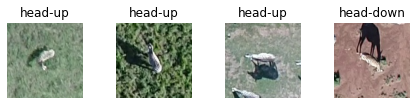

In [96]:
fig = plt.figure()

for i in range(len(HUHD_data)):
    sample = HUHD_data[i]
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    #ax.set_title('Sample #{}'.format(i))
    ax.set_title(sample['label'])
    ax.axis('off')
    plt.imshow(sample['image'])
    
    if i == 3:
        plt.show()
        break

Now the dataloader for the unlabeled images. I have a csv that lists all of the track segments with individual images, and which species is depicted in which segment. From this I pull out the zebra (grevy's and plains) track segments and include all images from these segments in the dataset. I then use the information in the image filenames to pull the pixel coordinates for the image.

This takes a long time and I'm sure that has something to do with the fact that we are dealing with 9 million images, but is also probably because my code is clunky and inefficient. Sorry Jake!

In [9]:
class HUHDUnlabeledDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): path to csv that lists species IDs of each track segment
        """
        delim =('/')
        # read in csv with the species ID for each track segment
        self.SpeciesIDs = pd.read_csv(csv_file)
        # subsample to include only zebras
        self.SpeciesIDs = self.SpeciesIDs[(self.SpeciesIDs['species'] == 'pz')| (self.SpeciesIDs['species'] == 'gz')]
        # segments from the same track should be of the same animal, so we can just deal with tracks instead of segments
        self.ZebTracks = [str(delim.join(p.split('/')[:-1])) for p in self.SpeciesIDs.segment]
        self.ZebTracks = np.unique(self.ZebTracks)
        # empty list for image filenames
        self.UnlabeledCrops = []
        # get all the image filenames
        for i in self.ZebTracks:
            i = str(i)
            for path, _, files in os.walk(i):
                for file in files:
                    self.UnlabeledCrops.append(os.path.join(path, file))
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.UnlabeledCrops)
    
    def __getitem__(self, idx):
        # get the image name
        img_name = self.UnlabeledCrops[idx]
        # get the observation ('observationxxx')
        obs = img_name.split('/')[7]
        # get the track ('track-xx')
        track = img_name.split('/')[9]
        # track number as an integer
        track_no = int(track.split('-')[1])
        # frame number as a string
        frame = img_name.split('/')[11].split('_')[2].split('.')[0]
        # read in the image
        image = io.imread(img_name)
        # find & load the tracks file for this observation
        tracks_file = os.path.join(self.root_dir, obs, 'localizations/tracks-complete-final.npy')
        tracks = np.load(tracks_file, allow_pickle = True)
        # get the first frame in which this individual appears
        first_frame = tracks[track_no]['first_frame']
        # subtract the first frame from the frame corresponding to the current image
        frame_adj = int(frame)-first_frame
        # use the adjusted frame number to get the pixel coordinates for this image
        coords = tracks[track_no]['track'][frame_adj]
        coords = coords.astype('float')
        sample = {'image': image, 'pix_coords_xy': coords, 'observation': obs, 'track': track, 'frame': frame}
        
        return sample
        

In [10]:
unlabeled_data = HUHDUnlabeledDataset(csv_file = '/Volumes/kenya_drones/vigilance/tracksegs_sppIDs.csv', 
                             root_dir = '/Volumes/kenya_drones/processing/kenya-tracking/processed-videos/raw-footage')

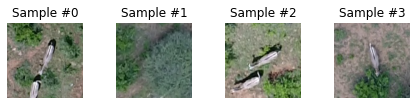

In [11]:
fig = plt.figure()

for i in range(len(unlabeled_data)):
    sample = unlabeled_data[i]
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    #ax.set_title(sample['label'])
    ax.axis('off')
    plt.imshow(sample['image'])
    
    if i == 3:
        plt.show()
        break